# Bike Share Rides Data Analysis

Analysis of a case study that was part of the Google Data Analytics Certificate.

Dataset describes a bike-share company in Chicago that is seeking to understand its user demographics and redesign it's marketing strategy to increase the number of users opting in for annual memberships. Dataset only covers data for 2019.

In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
%matplotlib inline

In [4]:
import datetime

In [5]:
bks_df = pd.read_csv('bike_share_rawdata.csv')

In [6]:
bks_df.head()

,trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear
0,21742443,01-01-2019 00:04,01-01-2019 00:11,2167,390,199,Wabash Ave & Grand Ave,84,Milwaukee Ave & Grand Ave,Subscriber,Male,1989.0
1,21742444,01-01-2019 00:08,01-01-2019 00:15,4386,441,44,State St & Randolph St,624,Dearborn St & Van Buren St (*),Subscriber,Female,1990.0
2,21742445,01-01-2019 00:13,01-01-2019 00:27,1524,829,15,Racine Ave & 18th St,644,Western Ave & Fillmore St (*),Subscriber,Female,1994.0
3,21742446,01-01-2019 00:13,01-01-2019 00:43,252,1783,123,California Ave & Milwaukee Ave,176,Clark St & Elm St,Subscriber,Male,1993.0
4,21742447,01-01-2019 00:14,01-01-2019 00:20,1170,364,173,Mies van der Rohe Way & Chicago Ave,35,Streeter Dr & Grand Ave,Subscriber,Male,1994.0


Based on the raw data provided we can explore the following questions:

- How many users are there in each user type (Subscriber/Customer)?
- How many users are there in each gender category?
- What is the average age of each user?
- What is the distribution of rides by age?
- What is the distribution of rides by day of week and month?
- What is the trip duration? What is the average trip duration across user types, ages and gender?
- When do trips usually begin? What time periods are the busiest?
- Which bike stations do the most rides begin/end at?

# Data Cleaning and Preparation

In this stage the data is checked for accuracy and completeness prior to beginning the analysis. 

- Removing extraneous data and outliers.
- Filling in missing values.
- Conforming data to a standardized pattern.
- Identifying errors revealed when new variables are created.
- Deleting data that cannot be corrected.

Note: There are no unique identifiers for each user so the data does not account for multiple trips made by users. Therefore, it will not be able to tell us how many unique users are associated with the ride data. 

# Checking for missing values

In [7]:
bks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365069 entries, 0 to 365068
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   trip_id            365069 non-null  int64  
 1   start_time         365069 non-null  object 
 2   end_time           365069 non-null  object 
 3   bikeid             365069 non-null  int64  
 4   tripduration       365069 non-null  int64  
 5   from_station_id    365069 non-null  int64  
 6   from_station_name  365069 non-null  object 
 7   to_station_id      365069 non-null  int64  
 8   to_station_name    365069 non-null  object 
 9   usertype           365069 non-null  object 
 10  gender             345358 non-null  object 
 11  birthyear          347046 non-null  float64
dtypes: float64(1), int64(5), object(6)
memory usage: 33.4+ MB


The gender and birthyear columns appear to have missing values. 

The missing values originate from a variety of reasons:
- The user may have forgotten to enter the value.  
- For missing gender values, the user may have identified with a different gender identify than the two options provided. 
- Hardware or software error in the bikes is affecting accuracy of trip data and so on.

As we are interested in Customer data it is important to identify how many of the missing vales belong to the Customers. Additionally, it is recommended to make both the above values a required field for user data collection purposes to avoid missing data in the future. 

In [8]:
##Rows with missing value for gender

bks_df['gender'].isnull().value_counts() 

False    345358
True      19711
Name: gender, dtype: int64

In [9]:
#Number of Customers with missing gender
bks_df[(bks_df['gender'].isnull()==True)& (bks_df['usertype']=="Customer")].count()

trip_id              17228
start_time           17228
end_time             17228
bikeid               17228
tripduration         17228
from_station_id      17228
from_station_name    17228
to_station_id        17228
to_station_name      17228
usertype             17228
gender                   0
birthyear              103
dtype: int64

The majority <i>(17228/19711)</i> of the missing gender values belong to the <b>Customer</b> data.

In [10]:
##Rows with missing value for birthyear

bks_df['birthyear'].isnull().value_counts() 

False    347046
True      18023
Name: birthyear, dtype: int64

In [11]:
#Number of Customers with missing birthyears
bks_df[(bks_df['birthyear'].isnull()==True)& (bks_df['usertype']=="Customer")].count()

trip_id              17126
start_time           17126
end_time             17126
bikeid               17126
tripduration         17126
from_station_id      17126
from_station_name    17126
to_station_id        17126
to_station_name      17126
usertype             17126
gender                   1
birthyear                0
dtype: int64

In [12]:
#Number of Subscribers with missing birthyears
bks_df[(bks_df['birthyear'].isnull()==True)& (bks_df['usertype']=="Subscriber")].count()

trip_id              897
start_time           897
end_time             897
bikeid               897
tripduration         897
from_station_id      897
from_station_name    897
to_station_id        897
to_station_name      897
usertype             897
gender                 0
birthyear              0
dtype: int64

The majority <i>(17126/18023)</i> of the missing birthyear values belong to the <b>Customer</b> data.

### Replacing Missing Values

As there are a significant number of Customer data points in the missing data, we need to replace the missing data to get a better picture of the customer behavior. The missing data for the Subscribers is relatively less significant compared to the number of Subscribers.

- We can replace missing gender values with a "Other Gender Identity" since we do not have the specific context stating otherwise. 
- We can replace missing birthyear vales with the average age for Customers. However, this will skew the age customer data towards the average of the customers who were not missing birthyear values.


In [13]:
bks_df['gender'] = bks_df['gender'].fillna("Other Gender Identity")

In [14]:
## We have replaced all missing gender values

bks_df['gender'].value_counts() 

Male                     278440
Female                    66918
Other Gender Identity     19711
Name: gender, dtype: int64

In [15]:
#Identifying average birthyear for each usertype
avg_age = bks_df.groupby('usertype')['birthyear'].mean().round()
avg_age

usertype
Customer      1989.0
Subscriber    1982.0
Name: birthyear, dtype: float64

In [16]:
#The following line of code helps identify all values in the birthyear column that are null for customer data:
#bks_df.loc[(bks_df['usertype']=='Customer') & (bks_df['birthyear'].isnull()==True),['birthyear']]

#Replacing missing values with the average customer age
bks_df.loc[(bks_df['usertype']=='Customer') & (bks_df['birthyear'].isnull()==True),['birthyear']] = bks_df.loc[(bks_df['usertype']=='Customer') & (bks_df['birthyear'].isnull()==True),['birthyear']].fillna(1989)

In [17]:
##Rows with missing value for birthyear have been replaced

bks_df['birthyear'].isnull().value_counts() 

False    364172
True        897
Name: birthyear, dtype: int64

The only remaining values that are mising are the subscribers with missing birthyear.

### Deleting Missing Values

In [18]:
bks_df.dropna(subset=['birthyear'], inplace=True)

In [19]:
## We have deleted all rows with missing birthyear values

bks_df['birthyear'].isnull().value_counts() 

False    364172
Name: birthyear, dtype: int64

In [20]:
bks_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 364172 entries, 0 to 365068
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   trip_id            364172 non-null  int64  
 1   start_time         364172 non-null  object 
 2   end_time           364172 non-null  object 
 3   bikeid             364172 non-null  int64  
 4   tripduration       364172 non-null  int64  
 5   from_station_id    364172 non-null  int64  
 6   from_station_name  364172 non-null  object 
 7   to_station_id      364172 non-null  int64  
 8   to_station_name    364172 non-null  object 
 9   usertype           364172 non-null  object 
 10  gender             364172 non-null  object 
 11  birthyear          364172 non-null  float64
dtypes: float64(1), int64(5), object(6)
memory usage: 36.1+ MB


All missing values have been dealt with.

## Correcting formatting issues in data

In [21]:
#Converting start time and end time to datetime values 

bks_df['start_time'] = pd.to_datetime(bks_df['start_time'])
bks_df['end_time'] = pd.to_datetime(bks_df['end_time'])

In [22]:
#Converting birthyear to int format
bks_df['birthyear'] = bks_df['birthyear'].astype(int)

## Checking for other issues with values

### Trip start and end times

In [23]:
#Checking for any instances where end time is earlier than the start time

(bks_df['end_time'] > bks_df['start_time']).value_counts()

True     364105
False        67
dtype: int64

The error could originate from a variety of reasons:
- Start and end times may have been swapped
- Start and end times may have been entered incorrectly
- Hardware or software error in the bikes is affecting accuracy of trip data and so on. 

As the source of the error is unknown, correcting the values is not possible so the associated rows will be deleted.

In [24]:
#Deleting rows where end time is earlier than start time

bks_df.drop(bks_df[bks_df['end_time'] < bks_df['start_time']].index, inplace = True)

In [25]:
#Rows have been sucessfully deleted

(bks_df['end_time'] > bks_df['start_time']).value_counts()

True    364105
dtype: int64

### Trip Duration

We have a column with <b>"tripduration"</b> that appears to be in seconds. However we have to check if the values are consistent with the actual trip duration.

In [26]:
# Calculating Trip duration in a new column
bks_df['trip_duration'] = bks_df['end_time'] - bks_df['start_time']

The trip duration calculated will be as a timedelta value which indicates the absolute time difference (for example "1 day 10:10:10")

In [27]:
#Checking if any trips exceed 1 day

(bks_df['trip_duration']>pd.Timedelta("1 days")).value_counts() 

False    363720
True        385
Name: trip_duration, dtype: int64

In [28]:
#Checking the longest trip duration

bks_df['trip_duration'].max()

Timedelta('302 days 12:38:00')

The bike share trips are meant for commutes around the city and it would not make sense for a trip to exceed one day. Therefore, we have incorrect values that need to be removed. 

In [29]:
#Deleting rows where end time is earlier than start time

bks_df.drop(bks_df[bks_df['trip_duration']>pd.Timedelta("1 days")].index, inplace = True)

In [30]:
#Rows with duration trips duration exceeding 1 day have been deleted

(bks_df['trip_duration']>pd.Timedelta("1 days")).value_counts() 

False    363720
Name: trip_duration, dtype: int64

Now that we have calculated the trip duration and removed the erroneous values, we can convert it to seconds

In [31]:
#Creating a new column where we will convert 'trip_duration' into seconds
bks_df['trip_duration_seconds'] = bks_df['trip_duration'].dt.total_seconds()

In [32]:
#Comparing values in the trip_duration_seconds to tripduration
(bks_df['trip_duration_seconds'] == bks_df['tripduration']).value_counts()

False    359096
True       4624
dtype: int64

It appears the majority of the values do not match, which presents three possibilities:
1. The <b>tripduration</b> values in the raw data may be capturing actual ride time in which case they may not include time the user is taking to unlock the bike, get on the bike etc. In this instance we can expect that the <b>tripduration</b> values to be lower than <b>trip_duration_seconds</b> values.
2. The <b>tripduration</b> values may be inaccurate, which could be leading to the discrepancy. 
3. The <b>start_time</b> and <b>end_time</b> values may be inaccurate, which could be leading to the discrepancy. 

In [33]:
#Comparing values in the trip_duration_seconds to tripduration to check if tripduration is always less than trip_duration_seconds
(bks_df['trip_duration_seconds'] > bks_df['tripduration']).value_counts()

False    183346
True     180374
dtype: int64

The <b>tripduration</b> values are not consistently lower than the <b>tripduration</b> values, so we can rule out the first possibility. 

In the absence of specific context, it is not possible to verify if the second or third possibility are true. Therefore, we will make the assumption that the <b>start_time</b> and <b>end_time</b> values are accurate and delete the <b>tripduration</b> column.

In [34]:
#Deleting the tripduration column
bks_df.drop('tripduration',axis=1, inplace=True)

## Creating new features

In this stage we are adding new features that will provide more insight into the data.

### Age

In [35]:
from datetime import date

bks_df['age'] = date.today().year - bks_df['birthyear']

### Day of week

In [36]:
#Identifying which day of the week the ride occured

bks_df['day_of_week'] = bks_df['end_time'].dt.day_name()

### Month

In [37]:
#Identifying which month the ride occured

bks_df['month'] = bks_df['end_time'].apply(lambda time: time.month)

In [38]:
#We needs to convert the values in the Month column from numbers to names of Months

dmap = {1:'January',2:'February',3:'March',4:'April',5:'May',6:'June',7:'July',8:'August',9:'September',10:'October',11:'November',12:'December'}

In [39]:
#Mapping our new dictionary to the Month column in the Dataframe

bks_df['month'] = bks_df['month'].map(dmap)

# Data Analysis and Visualization

In this stage, we will examine the data to identify any patterns, trends and relationships between the variables. It will help us analyze the data and extract insights that can be used to make decisions.

Data Visualization will gives us a clear idea of what the data means by giving it visual context.

### Checking for any correlation in the data

<AxesSubplot:>

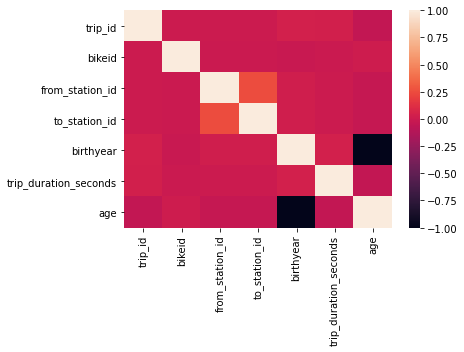

In [40]:
#Checking for any obvious correlation in the numeric variables
sns.heatmap(bks_df.corr())

There does not appear to be any significant and meaningful correlation between variables

### User Types

The users are divided into two types: <b> Subscribers</b> and <b>Customer</b>. 
    
- Users who purchase an annual membership fee are referred to as Subscribers 
- Users who purchase single-ride or full-day passes are referred to as Customers

In [41]:
#Number of trips associated with users in each category

bks_df['usertype'].value_counts()

Subscriber    340685
Customer       23035
Name: usertype, dtype: int64

In [42]:
Subscriber = 340685
Customer = 23035

round(Subscriber/Customer,1)

14.8

There are <b>14.8 times</b> more Subscribers than Customers

Text(0.5, 1.0, 'Number of Users of Each Type')

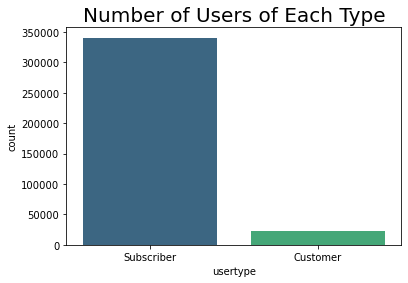

In [43]:
user_count = bks_df['usertype']
sns.countplot(x=user_count,data=bks_df,palette='viridis')
plt.title("Number of Users of Each Type", fontsize=20)

The users are overwhelmingly in the <b>Subscriber</b> category. The marketing strategy is therefore aimed at converting the relatively small number of users from Customers to Subscribers.

### Gender

In [44]:
#Number of trips associated with users of each gender

bks_df['gender'].value_counts()

Male                     278169
Female                    66851
Other Gender Identity     18700
Name: gender, dtype: int64

Text(0.5, 1.0, 'Percentage of Users in Each Gender Category')

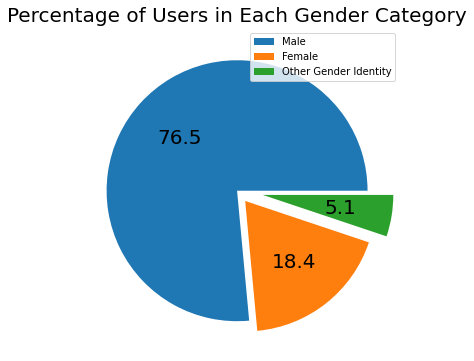

In [45]:
gender_df = bks_df['gender'].value_counts()

explode = (0, 0.1, 0.2)

gender_df.plot.pie(figsize=(6, 6), autopct="%.1f",fontsize=20,labels=None, legend=True, explode=explode).set_ylabel('')
plt.title("Percentage of Users in Each Gender Category", fontsize=20)

# autopct="%.1f" shows the percentage to 1 decimal place 
#.set_ylabel('') and can be added to remove the usertype label on the left of the chart.set_ylabel('')
# The explosion array specifies the fraction of the radius with which to offset each slice.

## Age

<b> Age statistics for all users</b>

In [46]:
print("Youngest user is ", bks_df['age'].min(),"years old")
print("Oldest user is ", bks_df['age'].max(),"years old")
print("Average user is ", round(bks_df['age'].mean()),"years old")
print("Average standard deviation in age is", round(bks_df['age'].std()),"years")

Youngest user is  18 years old
Oldest user is  121 years old
Average user is  39 years old
Average standard deviation in age is 11 years


<b> Age statistics by gender</b>

In [47]:
# Identifying the average age by gender 

bks_df.groupby('gender')['age'].mean().round()

gender
Female                   38.0
Male                     40.0
Other Gender Identity    33.0
Name: age, dtype: float64

Text(0.5, 1.0, 'Age Breakdown for Rides')

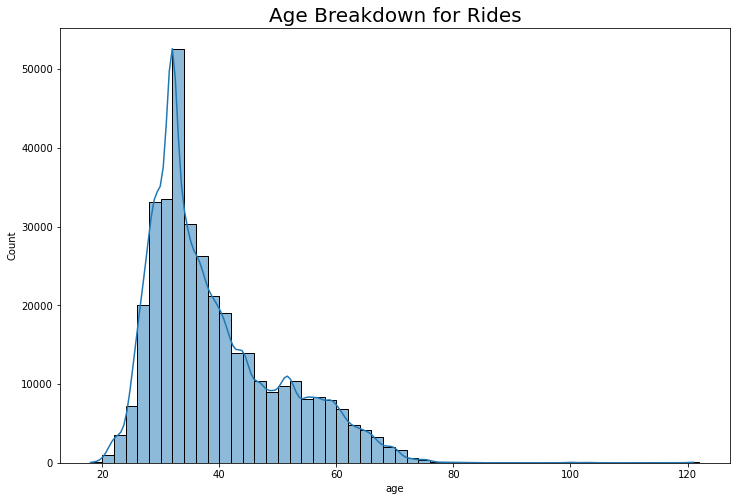

In [48]:
fig_dims = (12, 8)
fig, ax = plt.subplots(figsize=fig_dims)

sns.histplot(data=bks_df, x="age",binwidth=2,kde=True)
plt.title("Age Breakdown for Rides", fontsize=20)

Users <b>between the ages of 32-34</b> make the most rides overall.

Text(0.5, 0.98, 'Age breakdown by Usertype for Rides')

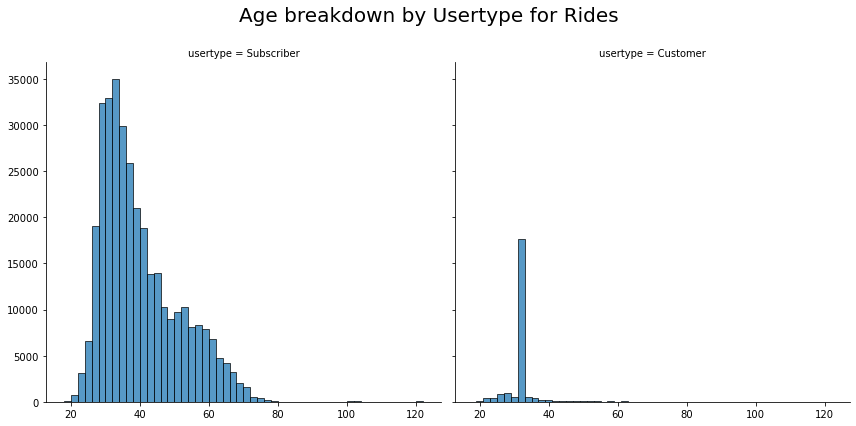

In [51]:
graph = sns.FacetGrid(bks_df, col="usertype", height=6)
graph.map_dataframe(sns.histplot,x="age",binwidth=2)

#Setting the title for the FacetGrid 
graph.fig.subplots_adjust(top=0.85)
graph.fig.suptitle('Age breakdown by Usertype for Rides', fontsize=20)

- Subscribers <b>between the ages of 32-34</b> make the most rides.
- Customers <b>between the ages of 31-33</b> make the most rides.

Text(0.5, 0.98, 'Age breakdown by Usertype and Gender for Rides')

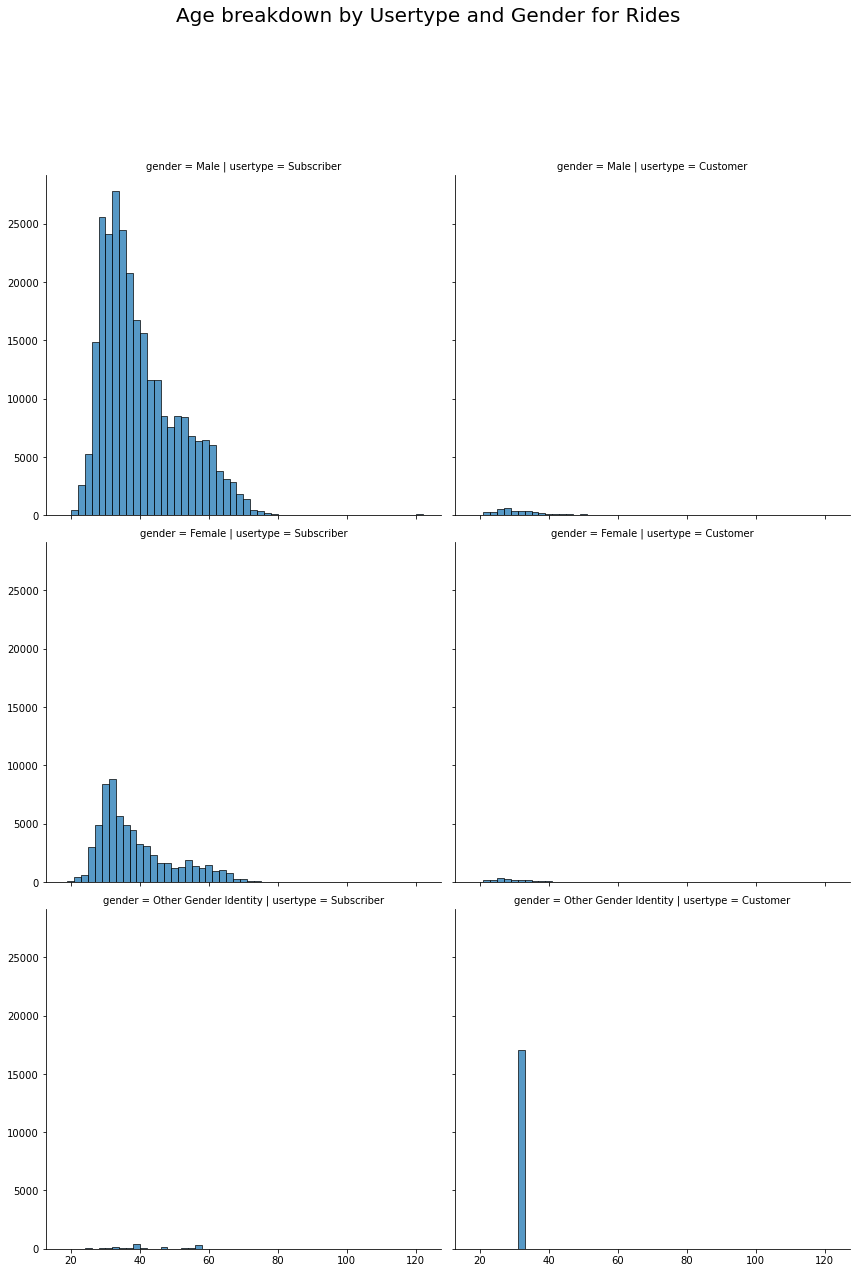

In [55]:
graph = sns.FacetGrid(bks_df, row="gender",col="usertype", height=6)
graph.map_dataframe(sns.histplot,x="age",binwidth=2)

#Setting the title for the FacetGrid 
graph.fig.subplots_adjust(top=0.85)
graph.fig.suptitle('Age breakdown by Usertype and Gender for Rides', fontsize=20)

<b>Subscribers</b>

- Male users <b>between the ages of 32-34</b> make the most rides.
- Female users <b>between the ages of 31-33</b> make the most rides.
- Other Gender Identity users <b>between the ages of 38-40</b> make the most rides.

<b>Customers</b>

- Male users <b>between the ages of 27-29</b> make the most rides.
- Female users <b>between the ages of 25-27</b> make the most rides.
- Other Gender Identity users <b>between the ages of 31-33</b> make the most rides

## Day of Week

In [262]:
#Number of rides on any given day of the week
bks_df['day_of_week'].value_counts()

Thursday     66543
Tuesday      59524
Wednesday    57915
Friday       57651
Monday       47113
Sunday       38558
Saturday     36416
Name: day_of_week, dtype: int64

Text(0.5, 1.0, 'Bike Share Ride Breakdown by Day of Week')

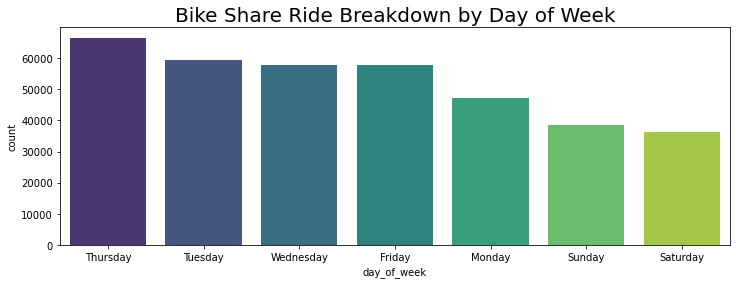

In [263]:
fig_dims = (12, 4)
fig, ax = plt.subplots(figsize=fig_dims)

# order = bks_df['day_of_week'].value_counts().index helps us sort the count plot by the value counts

sns.countplot(x='day_of_week',data=bks_df,order = bks_df['day_of_week'].value_counts().index,palette='viridis')
plt.title("Bike Share Ride Breakdown by Day of Week", fontsize=20)

<b>Thursdays</b> are the busiest days of the week for rides

## Month

In [264]:
bks_df['month'].value_counts()

March        127161
February      65249
January       54228
November      15997
April         15044
May           14915
August        14769
June          13483
July          13382
December      11520
September      9087
October        8885
Name: month, dtype: int64

Text(0.5, 1.0, 'Bike Share Ride Breakdown by Month')

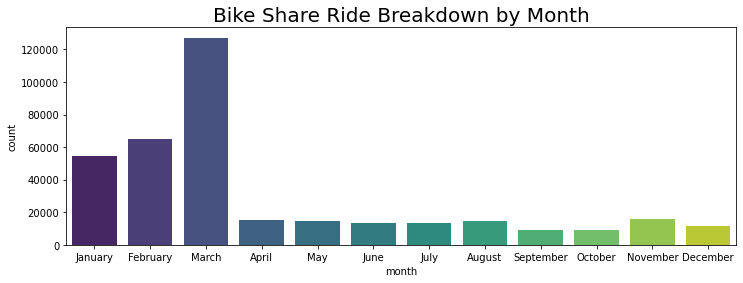

In [265]:
fig_dims = (12, 4)
fig, ax = plt.subplots(figsize=fig_dims)

#order = bks_df['month'].value_counts().index helps us sort the count plot by the value counts

sns.countplot(x='month',data=bks_df,palette='viridis')
plt.title("Bike Share Ride Breakdown by Month", fontsize=20)

There is a steep increase in rides starting from January with <b>March</b> being the busiest month for rides. The ridership drops off in April and does not fluctuate as significantly for the rest of the year.

## Trip Duration

<b> Trip Duration Statistics </b>

In [266]:
max_trip = bks_df['trip_duration'].max()
min_trip = bks_df['trip_duration'].min()
mean_trip = bks_df['trip_duration'].mean()
print("The longest trip duration was",max_trip,"\nThe shortest trip duration was",min_trip,"\nThe average trip duration was",mean_trip)

The longest trip duration was 0 days 23:29:00 
The shortest trip duration was 0 days 00:01:00 
The average trip duration was 0 days 00:12:36.275156713


Text(0.5, 1.0, 'Ride Duration Times')

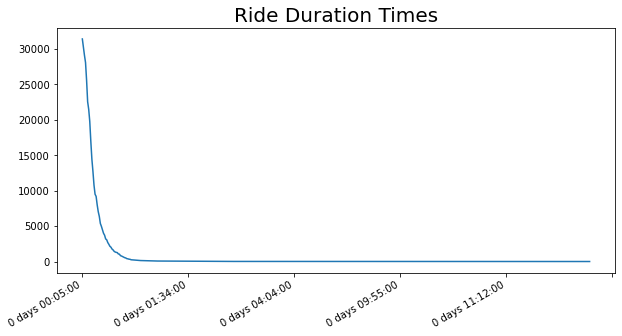

In [267]:
# Analyzing the trip duration times to identify any trends

fig_dims = (10, 5)
fig, ax = plt.subplots(figsize=fig_dims)

trip_duration_counts = bks_df['trip_duration'].value_counts()

trip_duration_counts.plot()

plt.title("Ride Duration Times", fontsize=20)

In [268]:
#Checking how many trips exceed the 1 hour mark
(bks_df['trip_duration']<pd.Timedelta("1 hour")).value_counts() 

True     359683
False      4037
Name: trip_duration, dtype: int64

As seen in the plot and the data above the <b>majority of trips do not exceed an hour.</b>

### Trip Duration by User Type

In [269]:
#Identifying the average trip duration for each user type
user_df = bks_df.groupby('usertype')['trip_duration_seconds'].mean().round()

#Converting the series user_df to a dataframe
user_df = user_df.to_frame()

#Converting 'trip_duration_seconds' back into timedelta format for readability 
user_df['average_trip_duration'] = user_df['trip_duration_seconds'].apply(lambda time: (datetime.timedelta(seconds = time))) 

#Dropping 'trip_duration_seconds' as it is no longer needed
user_df.drop('trip_duration_seconds',axis=1, inplace=True)

#Identifying number of trips for each user type
user_df['number_of_trips'] = bks_df['usertype'].value_counts()

user_df

,average_trip_duration,number_of_trips
usertype,,
Customer,0 days 00:34:23,23035
Subscriber,0 days 00:11:08,340685


In [271]:
cus = pd.to_timedelta("0 days 00:34:23")
sub = pd.to_timedelta("0 days 00:11:08")

round(cus/sub,1)

3.1

On average, <b>Customers make trips that are 3.1 times longer than Subscribers.</b>

<b>Note:</b> it would be useful to know the frequency of trips made by individual users to understand whether individual Customers trips more or less often than individual Subscribers. The marketing strategy may differ depending on the result. For example it is harder to convince a customer who takes a long trip once every few months to purchase an annual membership as opposed to a customer who takes a long trip more frequently. 

However, as mentioned before there are no unique identifiers for each user so the data does not account for multiple trips made by users. Therefore, it will not be able to tell us how many unique users are associated with the ride data. 

### Trip Duration, Number of Trips and Demographic Data

In [272]:
#Identifying the average trip duration for each user type
user_df = bks_df.groupby(['usertype','gender'])['trip_duration_seconds'].mean().round()

#Converting the series user_df to a dataframe
user_df = user_df.to_frame()

#Converting 'trip_duration_seconds' back into timedelta format for readability 
user_df['average_trip_duration'] = user_df['trip_duration_seconds'].apply(lambda time: (datetime.timedelta(seconds = time))) 

#Dropping 'trip_duration_seconds' as it is no longer needed
user_df.drop('trip_duration_seconds',axis=1, inplace=True)

#Identifying number of trips for each user type
user_df['number_of_trips'] = bks_df.groupby('usertype')['gender'].value_counts()

#Identifying average age by usertype and gender
user_df['average_age'] = bks_df.groupby(['usertype','gender'])['age'].mean().round()

user_df

average_trip_duration  number_of_trips  \
usertype   gender                                                         
Customer   Female                      0 days 00:35:40             1871   
           Male                        0 days 00:29:08             4045   
           Other Gender Identity       0 days 00:35:29            17119   
Subscriber Female                      0 days 00:11:53            64980   
           Male                        0 days 00:10:54           274124   
           Other Gender Identity       0 days 00:19:45             1581   

                                  average_age  
usertype   gender                              
Customer   Female                        31.0  
           Male                          32.0  
           Other Gender Identity         32.0  
Subscriber Female                        38.0  
           Male                          40.0  
           Other Gender Identity         43.0

In the <b>Customer</b> category
- Female users are making the longest trips.
- Average age range is 31-32.

In the <b>Subscriber</b> category
- Other Gender Identity users are making the longest trips.
- Average age range is 38-43.

Overall,
- On average, Customers are make longer trips than Subscribers in each gender category. 
- On average, Customers are younger than Subscribers. 
- Male users make the most trips in both categories. 

### Average Trip Duration by Day of Week

In [273]:
#Identifying the average trip on any given day of the week
day_of_week = bks_df.groupby(['usertype','day_of_week'])['trip_duration_seconds'].mean().round()

#Converting the series day_of_week to a dataframe
day_of_week = day_of_week.to_frame()

#Converting 'trip_duration_seconds' back into timedelta format for readability 
day_of_week['average_trip_duration'] = day_of_week['trip_duration_seconds'].apply(lambda time: (datetime.timedelta(seconds = time))) 

#Dropping 'trip_duration_seconds' as it is no longer needed
day_of_week.drop('trip_duration_seconds',axis=1, inplace=True)

#Sorting values by'average_trip_duration'
day_of_week.sort_values(by='average_trip_duration')


average_trip_duration
usertype   day_of_week                      
Subscriber Friday            0 days 00:10:44
           Tuesday           0 days 00:10:58
           Monday            0 days 00:10:59
           Thursday          0 days 00:11:02
           Sunday            0 days 00:11:14
           Wednesday         0 days 00:11:31
           Saturday          0 days 00:11:46
Customer   Monday            0 days 00:32:39
           Thursday          0 days 00:33:15
           Tuesday           0 days 00:33:18
           Saturday          0 days 00:33:31
           Friday            0 days 00:33:43
           Wednesday         0 days 00:34:37
           Sunday            0 days 00:38:39

Note: Directly using <b> bks_df.groupby(['usertype','day_of_week'])['trip_duration'].mean() </b> will not work because Python will not have any numeric data to aggregate

- On average, <b>Customers</b> make the longest trips on <b>Saturday</b> and the shortest trips on <b>Friday</b>
- On average, <b>Subscribers</b> make the longest trips on <b>Sunday</b> and the shortest trips on <b>Friday</b>

### Number of Trips by Day of Week

In [274]:
#Identifying number of trips on a given day of the week by user type
number_of_trips = bks_df.groupby('usertype')['day_of_week'].value_counts()

#Converting the series number_of_trips to a dataframe
number_of_trips = number_of_trips.to_frame()

number_of_trips

day_of_week
usertype   day_of_week             
Customer   Saturday            4752
           Wednesday           3722
           Sunday              3637
           Thursday            3145
           Friday              2800
           Tuesday             2773
           Monday              2206
Subscriber Thursday           63398
           Tuesday            56751
           Friday             54851
           Wednesday          54193
           Monday             44907
           Sunday             34921
           Saturday           31664

- <b>Customers</b> make the most trips on <b>Saturday</b> and the least trips on <b>Monday</b>
- <b>Subscribers</b> make the most trips on <b>Thursday</b> and the least trips on <b>Saturday</b>

### Trip Start Times

Text(0.5, 1.0, 'Ride Start Times throughout the Day')

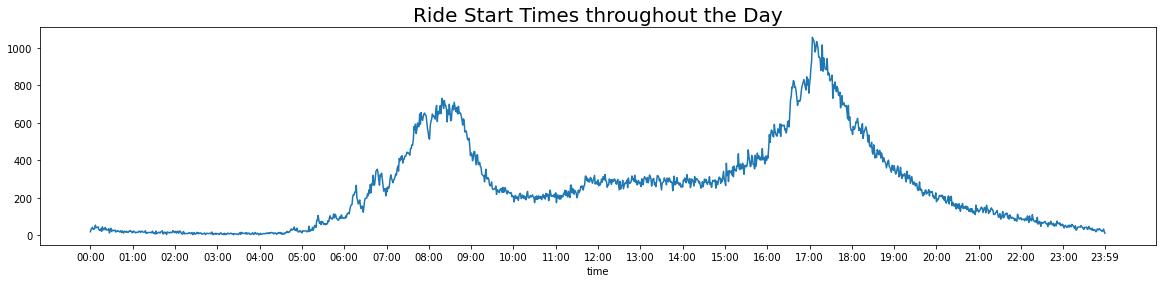

In [56]:
# Analyzing the trip start times to identify how many trips begin at various times throughout the day.

# Isolating the time portion from bks_df['start_time']
start_time = bks_df['start_time'].dt.time 

start_time_counts = start_time.value_counts()

#X-axis ticks will have to be set manually since the plot is difficult to read otherwise

#Creating a series that will be populated using a for loop 
time_series = []
for x in range(24):
    #Note {:02d} ensures there are leading zeros (01,02,etc.) which is consistent with time formatting
    time_series.append("{:02d}:00:00".format(x))

time_series.append("23:59:00")

fig_dims = (20, 4)
fig, ax = plt.subplots(figsize=fig_dims)

#The x-ticks are set to the time series just created
start_time_counts.plot(xticks=time_series)
plt.title("Ride Start Times throughout the Day", fontsize=20)

As seen above, the number of rides peaks at two different points on any given day, which correspond roughly with daily commute times where users may be heading to and from their workplaces.

<b>Morning Commute:</b> Rides begins to rise after 5 AM, reaching a peak between 8 AM and 9 AM and then plateau around 10 AM.

<b>Late Afternoon/Evening Commute:</b> Rides begins to rise after 3 PM, reaching a peak sometime after 5 PM peak and then continue to decrease until the end of the day. 

Text(0.5, 1.0, 'Customer Ride Start Times throughout the Day')

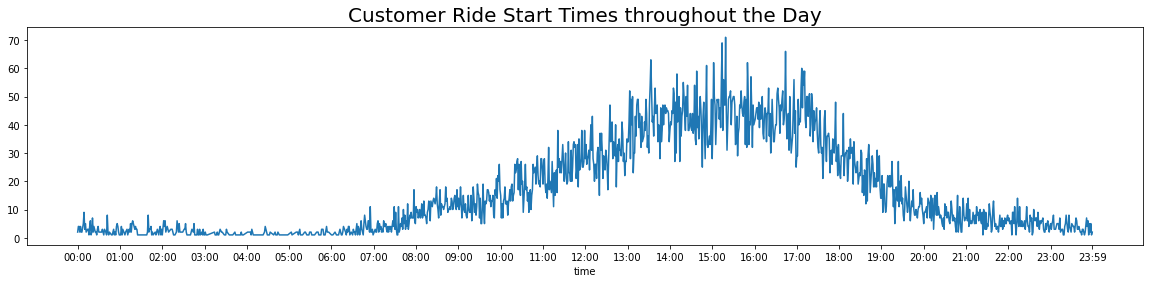

In [58]:
# Analyzing the trip start times to identify how many trips begin at various times throughout the day.

#Looking at Customer rides specifically
customer_trips = bks_df[bks_df["usertype"]=="Customer"]

# Isolating the time portion from bks_df['start_time']
start_time = customer_trips['start_time'].dt.time 

start_time_counts = start_time.value_counts()

#X-axis ticks will have to be set manually since the plot is difficult to read otherwise

#Creating a series that will be populated using a for loop 
time_series = []
for x in range(24):
    #Note {:02d} ensures there are leading zeros (01,02,etc.) which is consistent with time formatting
    time_series.append("{:02d}:00:00".format(x))

time_series.append("23:59:00")

fig_dims = (20, 4)
fig, ax = plt.subplots(figsize=fig_dims)

#The x-ticks are set to the time series just created
start_time_counts.plot(xticks=time_series)
plt.title("Customer Ride Start Times throughout the Day", fontsize=20)

Customer trips follow a different trend than the data overall. 

The rides began to rise after 6 AM, reaching a peak sometime after 3 PM and then continue to decrease until the end of the day. 

### Trip Start/End Locations

<b>Top ten bike stations where rides begin</b>

In [276]:
from_stations_df = bks_df['from_station_name'].value_counts().head(10)
from_stations_df = from_stations_df.to_frame()

#The index for this dataframe contains the station names so we want to put that information in a seaprate column
#Resetting the index (also creates a new column called 'index')
from_stations_df.reset_index(level=0, inplace=True)

#Renaming 'from_station_name' which contains value counts to 'number_of_trips_start' and renaming the 'index' column to 'start_station_name'
from_stations_df.rename(columns={'from_station_name': 'number_of_trips_start', 'index':'start_station_name'}, inplace=True)

from_stations_df

,start_station_name,number_of_trips_start
0,Clinton St & Washington Blvd,7653
1,Clinton St & Madison St,6512
2,Canal St & Adams St,6335
3,Columbus Dr & Randolph St,4651
4,Canal St & Madison St,4569
5,Kingsbury St & Kinzie St,4389
6,Michigan Ave & Washington St,3986
7,Franklin St & Monroe St,3509
8,Dearborn St & Monroe St,3243
9,LaSalle St & Jackson Blvd,3234


<b>Top ten bike stations where rides end</b>

In [277]:
to_stations_df = bks_df['to_station_name'].value_counts().head(10)
to_stations_df = to_stations_df.to_frame()

#Resetting the index 
to_stations_df.reset_index(level=0, inplace=True)

#Renaming columns
to_stations_df.rename(columns={'to_station_name': 'number_of_trips_end', 'index':'end_station_name'}, inplace=True)

to_stations_df 

,end_station_name,number_of_trips_end
0,Clinton St & Washington Blvd,7657
1,Clinton St & Madison St,6840
2,Canal St & Adams St,6741
3,Canal St & Madison St,4870
4,Michigan Ave & Washington St,4408
5,Kingsbury St & Kinzie St,4368
6,LaSalle St & Jackson Blvd,3302
7,Clinton St & Lake St,3293
8,Dearborn St & Monroe St,3133
9,Clinton St & Jackson Blvd (*),3111


There's a lot of overlap in the top 10 stations where rides begin/end so it is useful to identify which stations appear in both lists.

<b>Stations that appear on both lists</b>

In [278]:
#Creating two series each with the names of the top 10 stations
start = from_stations_df['start_station_name']
end = to_stations_df['end_station_name']

#Identifying the intersection of both series
pd.Series(list(set(start) & set(end)))

0         Clinton St & Madison St
1             Canal St & Adams St
2    Michigan Ave & Washington St
3    Clinton St & Washington Blvd
4         Dearborn St & Monroe St
5           Canal St & Madison St
6       LaSalle St & Jackson Blvd
7        Kingsbury St & Kinzie St
dtype: object

The bike stations listed are <b>points where the most rides both begin and end</b>, which makes them ideal locations for marketing promotions.  

We can further explore what the top stations are by usertype. As we are primarily interested in converting Customers to Subscribers, it is valuable to know which stations marketing efforts should be focused on to target customers.

<b>Top ten bike stations where rides begin for <i>Customers</i> </b>

In [286]:
#Identifying Customers
customers_from_stations = bks_df[bks_df['usertype']=="Customer"]

#Identifying top 5 stations where Customers begin trips from
customers_from_stations = customers_from_stations.groupby('usertype')['from_station_name'].value_counts().head(10)
customers_from_stations = customers_from_stations.to_frame()

#Renaming columns
customers_from_stations.rename(columns={'from_station_name': 'number_of_trips'}, inplace=True)

customers_from_stations

number_of_trips
usertype from_station_name                            
Customer Streeter Dr & Grand Ave                  1218
         Lake Shore Dr & Monroe St                1140
         Shedd Aquarium                            833
         Millennium Park                           622
         Michigan Ave & Oak St                     386
         Adler Planetarium                         361
         Dusable Harbor                            342
         Michigan Ave & Washington St              342
         Field Museum                              298
         Buckingham Fountain (Temp)                256

<b>Top five bike stations where rides end for <i>Customers</i> </b>

In [287]:
#Identifying Customers
customers_to_stations = bks_df[bks_df['usertype']=="Customer"]

#Identifying top 5 stations where Customers begin trips from
customers_to_stations = customers_to_stations.groupby('usertype')['to_station_name'].value_counts().head(10)
customers_to_stations = customers_to_stations.to_frame()

#Renaming columns
customers_to_stations.rename(columns={'to_station_name': 'number_of_trips'}, inplace=True)

customers_to_stations

number_of_trips
usertype to_station_name                              
Customer Streeter Dr & Grand Ave                  1931
         Lake Shore Dr & Monroe St                 891
         Millennium Park                           818
         Shedd Aquarium                            639
         Michigan Ave & Oak St                     447
         Michigan Ave & Washington St              409
         Theater on the Lake                       348
         Adler Planetarium                         295
         Lake Shore Dr & North Blvd                286
         Wabash Ave & Grand Ave                    242

<b>Stations that appear on both lists</b>

In [291]:
#As the station names are part of the MultiIndex for the data frames we need to rest the index
customers_from_stations.reset_index(level=0, inplace=True)
customers_to_stations.reset_index(level=0, inplace=True)

In [292]:
#Creating two series each with the names of the top 10 stations
start = customers_from_stations['from_station_name']
end = customers_to_stations['to_station_name']

#Identifying the intersection of both series
pd.Series(list(set(start) & set(end)))

0         Streeter Dr & Grand Ave
1    Michigan Ave & Washington St
2               Adler Planetarium
3       Lake Shore Dr & Monroe St
4                  Shedd Aquarium
5                 Millennium Park
6           Michigan Ave & Oak St
dtype: object

The bike stations listed are <b>points where the most rides both begin and end for <i>Customers</i></b>, which makes them ideal locations for marketing promotions <i>specifically targeted</i> at them.

# Summary of Customer Data

- There are 23,035 customer. 
- There are 14.8 times more Subscribers than Customers

<b>Age</b>
- On average, Customers are younger than Subscribers.
- Customers between the ages of 31-33 make the most rides.

    - Male users between the ages of 27-29 make the most rides.
    - Female users between the ages of 25-27 make the most rides.
    - Other Gender Identity users between the ages of 31-33 make the most rides

<b>Trip Duration</b>

- The majority of trips do not exceeed an hour.
- On average, Customers make trips that are 3.1 times longer than Subscribers.

    - Male users make the most trips.
    - Female users are making the longest trips.
    - Average age range is 31-32.

<b>Day of Week</b>
- On average, Customers make the longest trips on Saturday and the shortest trips on Friday
- Customers make the most trips on Saturday and the least trips on Monday

<b>Start Times and Stations</b>
- The rides began to rise after 6 AM, reaching a peak sometime after 3 PM and then continue to decrease until the end of the day.
- The bike stations listed are points where the most rides both begin and end for Customers, which makes them ideal locations for marketing promotions specifically targeted at them.
- The bike stations listed are points where the most rides both begin and end, which makes them ideal locations for marketing promotions.

    - Streeter Dr & Grand Ave
    - Michigan Ave & Washington St
    - Adler Planetarium
    - Lake Shore Dr & Monroe St
    - Shedd Aquarium
    - Millennium Park
    - Michigan Ave & Oak St




# Reccomendations

<b>Focus on what is valuable to Customers</b>

- Customers make longer trips than Subscribers. Longer trips will have a higher cost for the customer. The marketing team could highlight the decrease in cost from switching to becoming a Subscriber. The trip duration does not vary significantly for Customers regardless of the day of the week. Therefore, depending on the frequency of use by each customer, the customer would stand to save a significant amount by switching.
<br>
- Customers have a slight preference for weekend trips, The marketing teams could offer deals for Customers who choose to become Subscribers on a weekend. 
<br>
- Customers also tend to be younger than Subscribers (primarily in their early 30's) so the marketing campaign should cater to the interests of this demographic. Customers may be using the bike share service for personal use such as running errands, travelling to meet someone etc. The marketing team could survey Customers to find out their interests and offer promotions such as discounts at grocery stores, a discounted annual price for referring friends etc. depending on their interests. 
<br>
- The majority of Customers and Subscribers appear to be men. Therefore, the marketing team may want to change their marketing campaign to attract female users and users of other gender identities and expand their user base.
<br>
- Customer rides also appear to not follow the traditional commuting patterns, which may suggest that the customers either do not work traditional office jobs that require them to commute to and from work. Therefore the key time period to market promotions would be around 3 PM when the most rides are occuring. 
<br>
- The Marketing team should distribute promotional materials at the stations identified that see the most traffic, where the majority of Customer tier trips begin and end. These locations are frequented the most by customers and provides an opportunity to entice them to make the switch to become Subscribers.

<b>Additional Data necessary</b><br>
The company should associate a unique customer id with each trip to identify individual customer behaviors. The unique identifiers would reveal information on the frequency of bike trips made by each customer. For example, it would reveal how many trips each customer makes a week on average, which may reveal if there are specific differences or similarities in the two tiers of customers.